In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Data processing

In [2]:
# Drop ID
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [3]:
# axList = train["SalePrice"].hist(bins=25, figsize=(4,4))

In [4]:
# Log is used to respond to skewness towards large values 
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)
# axList = train["SalePrice"].hist(bins=25, figsize=(4,4))

In [5]:
corr_matrix = train.corr(method='pearson')
corr_matrix['SalePrice'].sort_values(kind="quicksort")

EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
MSSubClass      -0.073959
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
BsmtHalfBath    -0.005149
BsmtFinSF2       0.004832
3SsnPorch        0.054900
MoSold           0.057330
PoolArea         0.069798
ScreenPorch      0.121208
BedroomAbvGr     0.209043
BsmtUnfSF        0.221985
BsmtFullBath     0.236224
LotArea          0.257320
HalfBath         0.313982
2ndFlrSF         0.319300
OpenPorchSF      0.321053
WoodDeckSF       0.334135
LotFrontage      0.355879
BsmtFinSF1       0.372023
MasVnrArea       0.430809
Fireplaces       0.489450
TotRmsAbvGrd     0.534422
GarageYrBlt      0.541073
YearRemodAdd     0.565608
YearBuilt        0.586570
FullBath         0.594771
1stFlrSF         0.596981
TotalBsmtSF      0.612134
GarageArea       0.650888
GarageCars       0.680625
GrLivArea        0.700927
OverallQual      0.817185
SalePrice        1.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

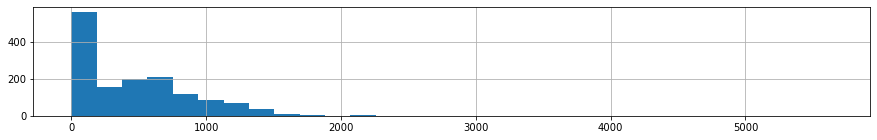

In [6]:
train["BsmtFinSF1"].hist(bins=30, figsize=(15,2))

<AxesSubplot:>

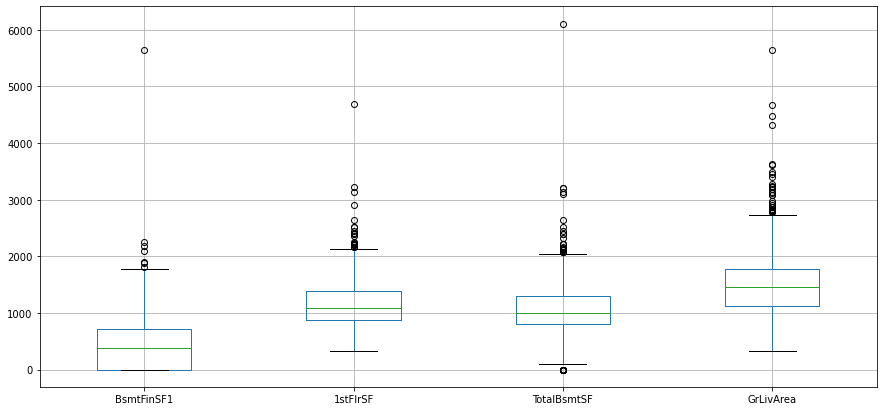

In [7]:
train.boxplot(figsize=(15,7), column=[
'BsmtFinSF1',
'1stFlrSF',
'TotalBsmtSF',
'GrLivArea',])

<AxesSubplot:>

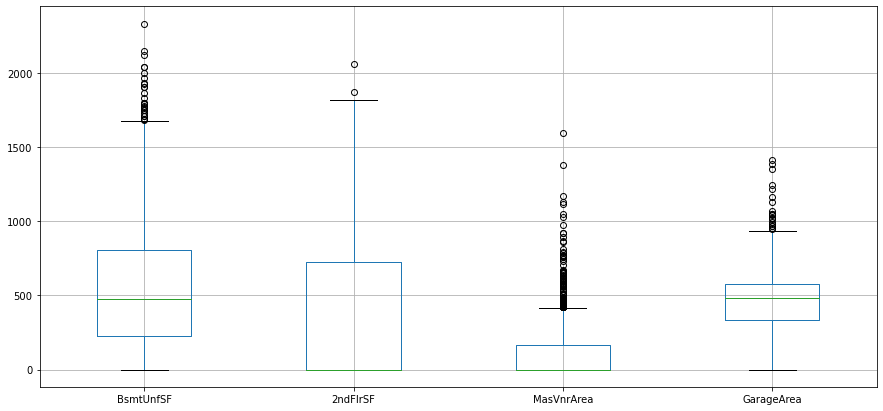

In [8]:
train.boxplot(figsize=(15,7), column=[
'BsmtUnfSF',
'2ndFlrSF',
'MasVnrArea',
'GarageArea',
])

In [9]:
train[train['2ndFlrSF'] > 1500]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,2Story,10,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,1031.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1410,1410,GasA,Ex,Y,SBrkr,1426,1519,0,2945,0,0,3,1,3,1,Gd,10,Typ,1,Gd,BuiltIn,2006.0,Fin,3,641,TA,TA,Y,192,0,37,0,0,0,NaN,NaN,NaN,0,10,2006,New,Partial,12.991756
118,60,RL,90.0,12376,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1990,1990,Hip,CompShg,Plywood,Plywood,None,0.0,TA,TA,PConc,Gd,TA,Mn,GLQ,1470,Unf,0,203,1673,GasA,Gd,Y,SBrkr,1699,1523,0,3222,1,0,3,0,5,1,Gd,11,Typ,2,TA,Attchd,1990.0,Unf,3,594,TA,TA,Y,367,0,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,12.676079
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,13.071072
304,75,RM,87.0,18386,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Fin,7,9,1880,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,1470,1470,GasA,Ex,Y,SBrkr,1675,1818,0,3493,0,0,3,0,3,1,Gd,10,Typ,1,Ex,Attchd,2003.0,Unf,3,870,TA,TA,Y,302,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,12.594734
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,12.126764
691,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,13.534474
745,60,RL,NaN,8963,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,9,1976,1996,Hip,CompShg,VinylSd,VinylSd,BrkFace,289.0,Ex,Gd,CBlock,TA,Gd,No,GLQ,575,ALQ,80,487,1142,GasA,Ex,Y,SBrkr,1175,1540,0,2715,0,1,3,1,4,1,Gd,11,Typ,2,TA,BuiltIn,1994.0,Fin,2,831,TA,TA,Y,0,204,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,12.610874
769,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,13.195616
1169,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,13.345509
1182,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd 

<AxesSubplot:>

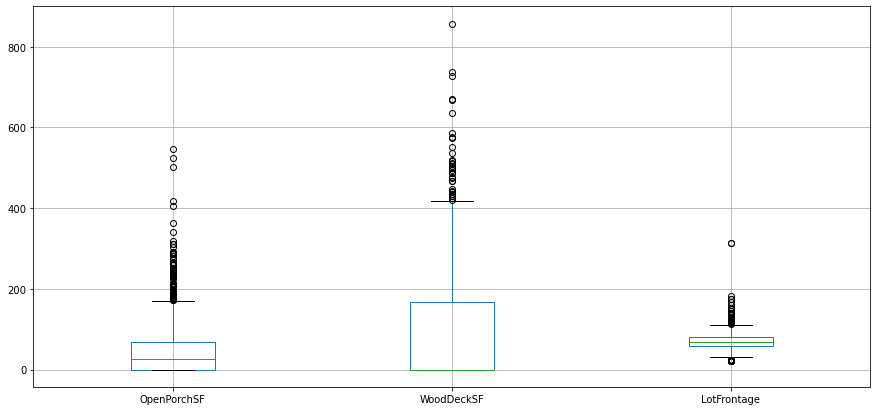

In [10]:
train.boxplot(figsize=(15,7), column=[
'OpenPorchSF',
'WoodDeckSF',
'LotFrontage',
])

<AxesSubplot:>

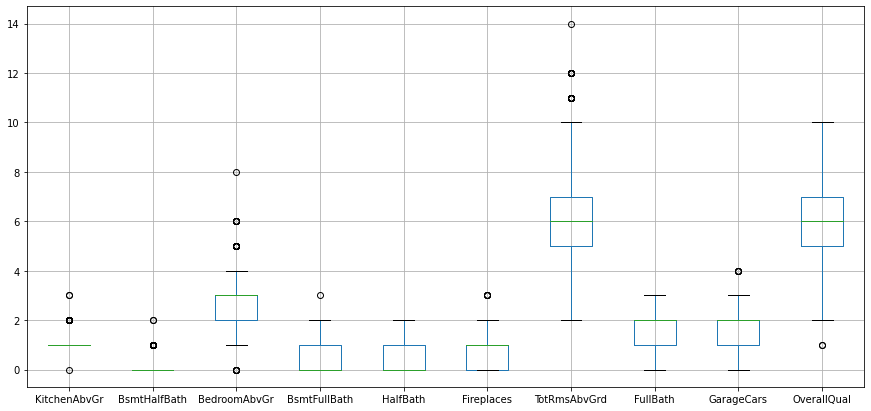

In [11]:
train.boxplot(figsize=(15,7), column=[

'KitchenAbvGr',
'BsmtHalfBath',
'BedroomAbvGr',
'BsmtFullBath',
'HalfBath',
'Fireplaces',
'TotRmsAbvGrd',
'FullBath',
'GarageCars',
'OverallQual'
])

In [12]:
train[train['BsmtFullBath'] > 2]
train[train['OverallQual'] < 2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
375,30,RL,NaN,10020,Pave,NaN,IR1,Low,AllPub,Inside,Sev,Edwards,Norm,Norm,1Fam,1Story,1,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,BrkTil,Fa,Po,Gd,BLQ,350,Unf,0,333,683,GasA,Gd,N,FuseA,904,0,0,904,1,0,0,1,1,1,Fa,4,Maj1,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal,11.018646
533,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,Inside,Mod,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,FuseF,334,0,0,334,0,0,1,0,1,1,Fa,2,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,10.579005


<AxesSubplot:>

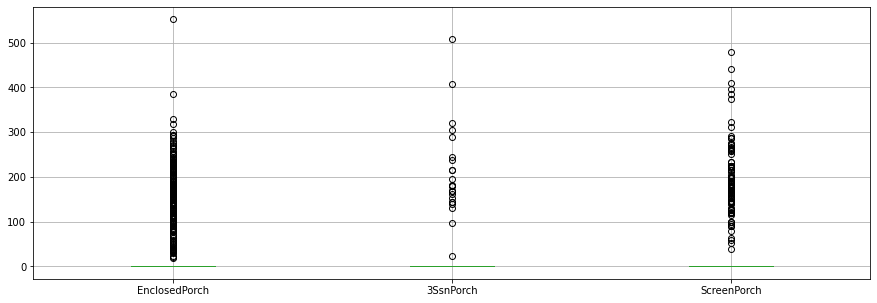

In [13]:
train.boxplot(figsize=(15,5), column=[
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch'
])

<AxesSubplot:>

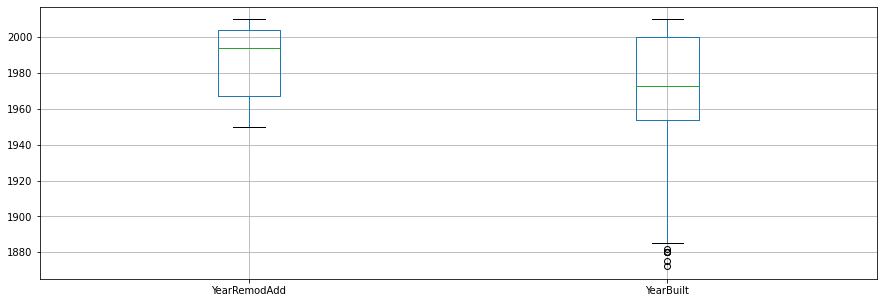

In [14]:

train.boxplot(figsize=(15,5), column=[
#'YrSold',
#'MoSold',
'YearRemodAdd',
'YearBuilt'
])

In [15]:
train[train['YearBuilt'] < 1900]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
106,30,RM,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,7,1885,1995,Mansard,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,0,Unf,0,641,641,GasA,Gd,Y,SBrkr,1047,0,0,1047,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1954.0,Unf,1,273,Fa,Fa,N,0,0,0,0,0,0,NaN,NaN,Shed,450,8,2007,WD,Normal,11.512935
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,13.071072
304,75,RM,87.0,18386,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Fin,7,9,1880,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,1470,1470,GasA,Ex,Y,SBrkr,1675,1818,0,3493,0,0,3,0,3,1,Gd,10,Typ,1,Ex,Attchd,2003.0,Unf,3,870,TA,TA,Y,302,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,12.594734
583,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,PosA,1Fam,2.5Unf,10,9,1893,2000,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Ex,Ex,BrkTil,TA,TA,No,Unf,0,Unf,0,1237,1237,GasA,Gd,Y,SBrkr,1521,1254,0,2775,0,0,3,1,3,1,Gd,9,Typ,1,Gd,Detchd,1988.0,Unf,2,880,Gd,TA,Y,105,502,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,12.691584
630,70,RM,50.0,9000,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,1Fam,2Story,5,6,1880,1991,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,Fa,Fa,No,Unf,0,Unf,0,636,636,GasA,TA,Y,FuseA,1089,661,0,1750,0,0,1,0,3,1,Ex,8,Typ,0,NaN,Detchd,1937.0,Unf,1,240,Fa,Po,N,0,0,293,0,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Abnorml,11.728045
716,70,RM,60.0,10800,Pave,Grvl,Reg,Bnk,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,8,1890,1998,Gable,CompShg,Wd Sdng,VinylSd,None,0.0,TA,Gd,BrkTil,TA,TA,No,Unf,0,Unf,0,718,718,GasA,Ex,Y,SBrkr,1576,978,0,2554,0,0,1,1,3,1,TA,8,Typ,0,NaN,Detchd,1996.0,Unf,2,704,TA,TA,P,0,48,143,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal,11.979805
747,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,7,1880,2003,Mansard,CompShg,Stucco,Stucco,None,0.0,Gd,TA,Stone,TA,Fa,No,Unf,0,Unf,0,1240,1240,GasW,TA,N,SBrkr,1320,1320,0,2640,0,0,1,1,4,1,Gd,8,Typ,1,Gd,Detchd,1950.0,Unf,4,864,TA,TA,N,181,0,386,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,12.491176
809,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2.5Unf,5,5,1898,1965,Hip,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,849,849,GasA,TA,N,FuseA,1075,1063,0,2138,0,0,2,0,2,3,TA,11,Typ,0,NaN,Detchd,1910.0,Unf,2,360,Fa,Po,N,40,156,0,0,0,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,11.571204
945,50,RM,98.0,8820,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,6,1890,1996,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,1088,Unf,0,0,1088,GasA,TA,Y,SBrkr,1188,561,120,1869,0,0,1,0,2,1,TA,7,Typ,0,NaN,Detchd,1963.0,Unf,2,456,TA,TA,Y,48,0,244,0,0,0,NaN,MnWw,NaN,0,9,2009,WD,Normal,11.735277
991,70,RM,121.0,17671,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,1Fam,2Story,8,9,1882,1986,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,No

In [16]:
# Put test & train features to one df
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [17]:
# Exploring NaN
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    return mis_val_table_ren_columns
missing_values_table(features)

,Missing Values,% of Total Values
PoolQC,2909,99.7
MiscFeature,2814,96.4
Alley,2721,93.2
Fence,2348,80.4
FireplaceQu,1420,48.6
LotFrontage,486,16.6
GarageFinish,159,5.4
GarageQual,159,5.4
GarageCond,159,5.4
GarageYrBlt,159,5.4


In [18]:
# Removing features that are not very useful:
# - more then 48% of NaN at start : 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu'
features = features.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1)

In [19]:
# Since these column are actually a category , using a numerical number will lead the model to assume
# that it is numerical , so we convert to string .
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [20]:
print(features['Functional'].value_counts(dropna=False))
print(features['Electrical'].value_counts(dropna=False))
print(features['KitchenQual'].value_counts(dropna=False))

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
NaN        2
Sev        2
Name: Functional, dtype: int64
SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: Electrical, dtype: int64
TA     1492
Gd     1151
Ex      205
Fa       70
NaN       1
Name: KitchenQual, dtype: int64


In [21]:
## Filling these columns With most suitable value for these columns 
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 

In [22]:
print(features['Exterior1st'].value_counts(dropna=False))
print(features['Exterior2nd'].value_counts(dropna=False))
print(features['SaleType'].value_counts(dropna=False))

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
NaN           1
ImStucc       1
Name: Exterior1st, dtype: int64
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
NaN           1
Name: Exterior2nd, dtype: int64
WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
NaN         1
Name: SaleType, dtype: int64


In [23]:
## Filling these with MODE, i.e. , the most frequent value in these columns .
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [24]:
### Missing data in GarageYrBit most probably means missing Garage, so replace NaN with zero . 
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

### Same with basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

In [25]:
"""
# Since these column are actually a category , using a numerical number will lead the model to assume
# that it is numerical , so we convert to string .
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

## Filling these columns With most suitable value for these columns 
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")

## Filling these with MODE, i.e. , the most frequent value in these columns .
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

### Missing data in GarageYrBit most probably means missing Garage, so replace NaN with zero . 
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

### Same with basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')
"""

'\n# Since these column are actually a category , using a numerical number will lead the model to assume\n# that it is numerical , so we convert to string .\nfeatures[\'MSSubClass\'] = features[\'MSSubClass\'].apply(str)\nfeatures[\'YrSold\'] = features[\'YrSold\'].astype(str)\nfeatures[\'MoSold\'] = features[\'MoSold\'].astype(str)\n\n## Filling these columns With most suitable value for these columns \nfeatures[\'Functional\'] = features[\'Functional\'].fillna(\'Typ\') \nfeatures[\'Electrical\'] = features[\'Electrical\'].fillna("SBrkr") \nfeatures[\'KitchenQual\'] = features[\'KitchenQual\'].fillna("TA") \nfeatures["PoolQC"] = features["PoolQC"].fillna("None")\n\n## Filling these with MODE, i.e. , the most frequent value in these columns .\nfeatures[\'Exterior1st\'] = features[\'Exterior1st\'].fillna(features[\'Exterior1st\'].mode()[0]) \nfeatures[\'Exterior2nd\'] = features[\'Exterior2nd\'].fillna(features[\'Exterior2nd\'].mode()[0])\nfeatures[\'SaleType\'] = features[\'SaleType\']

In [26]:
missing_values_table(features)

,Missing Values,% of Total Values
LotFrontage,486,16.6
MasVnrType,24,0.8
MasVnrArea,23,0.8
MSZoning,4,0.1
Utilities,2,0.1
BsmtFullBath,2,0.1
BsmtHalfBath,2,0.1
BsmtFinSF1,1,0.0
BsmtFinSF2,1,0.0
BsmtUnfSF,1,0.0


In [27]:
# This code will filll the missing values with the mode 
# (The frequently category appearing) By each MSsubclass:
# Idea is that similar MSSubClasses will have similar MSZoning
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# Fill the remaining columns as None
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

In [28]:
missing_values_table(features)

,Missing Values,% of Total Values
LotFrontage,486,16.6
MasVnrArea,23,0.8
BsmtFullBath,2,0.1
BsmtHalfBath,2,0.1
BsmtFinSF1,1,0.0
BsmtFinSF2,1,0.0
BsmtUnfSF,1,0.0
TotalBsmtSF,1,0.0


<AxesSubplot:>

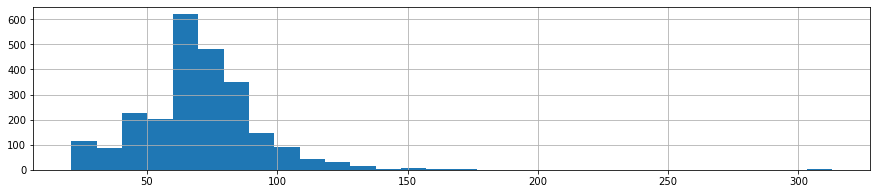

In [29]:
features["LotFrontage"].hist(bins=30, figsize=(15,3))

In [30]:
# For missing values in numerical cols , we fillNa with 0
# We are still filling up missing values 
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))


numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [31]:
missing_values_table(features)

,Missing Values,% of Total Values


In [32]:
features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,14.663551,13.424520,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.989638,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.378557,Gd,TA,PConc,Gd,TA,No,GLQ,117.855863,Unf,0.0,30.016554,296.832332,GasA,Ex,Y,SBrkr,5.318379,1019.540733,0.0,7.234115,0.992784,0.00000,2,1.069352,3,0.75096,Gd,2.238462,Typ,0.000000,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.000000,12.009558,0.000000,0.0,0.0,0.0,0.000000,2,2008,WD,Normal
1,20,RL,16.494888,13.694527,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,5.996435,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,146.805798,Unf,0.0,44.178886,407.302419,GasA,Ex,Y,SBrkr,5.550627,0.000000,0.0,6.947212,0.000000,0.71081,2,0.000000,3,0.75096,TA,1.978208,Typ,0.900816,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,56.339208,0.000000,0.000000,0.0,0.0,0.0,0.000000,5,2007,WD,Normal
2,60,RL,15.044952,14.034133,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.989638,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.721069,Gd,TA,PConc,Gd,TA,Mn,GLQ,91.575284,Unf,0.0,56.957793,314.805061,GasA,Ex,Y,SBrkr,5.362015,1034.306417,0.0,7.275132,0.992784,0.00000,2,1.069352,3,0.75096,Gd,1.978208,Typ,0.900816,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.000000,9.849185,0.000000,0.0,0.0,0.0,0.000000,9,2008,WD,Normal
3,70,RL,14.008495,13.683421,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.989638,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,52.776367,Unf,0.0,64.881733,268.234291,GasA,Gd,Y,SBrkr,5.388291,899.200533,0.0,7.237969,0.992784,0.00000,1,0.000000,3,0.75096,Gd,2.116352,Typ,0.900816,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.000000,8.921746,16.012025,0.0,0.0,0.0,0.000000,2,2006,WD,Abnorml
4,60,RL,16.954473,14.550142,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.989638,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.323127,Gd,TA,PConc,Gd,TA,Av,GLQ,112.040325,Unf,0.0,61.233855,376.259367,GasA,Ex,Y,SBrkr,5.493032,1265.167706,0.0,7.470741,0.992784,0.00000,2,1.069352,4,0.75096,Gd,2.347900,Typ,0.900816,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,42.351292,14.180238,0.000000,0.0,0.0,0.0,0.000000,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,7.529561,10.503897,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,5.345038,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,TA,CBlock,TA,TA,No,Unf,0.000000,Unf,0.0,65.309791,205.682501,GasA,Gd,Y,SBrkr,5.041055,643.029767,0.0,6.810355,0.000000,0.00000,1,1.069352,3,0.75096,TA,1.819119,Typ,0.000000,None,0.0,None,0.0,0.0,None,None,Y,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,6,2006,WD,Normal
2915,160,RM,7.529561,10.463055,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,3.989638,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,TA,CBlock,TA,TA,No,Rec,58.629117,Unf,0.0,45.107590,205.682501,GasA,TA,Y,SBrkr,5.041055,643.029767,0.0,6.810355,0.000000,0.00000,1,

# Feature Engineering

In [33]:
print(features['Utilities'].value_counts(dropna=False))
print(features['Street'].value_counts(dropna=False))

AllPub    2916
None         2
NoSeWa       1
Name: Utilities, dtype: int64
Pave    2907
Grvl      12
Name: Street, dtype: int64


In [34]:
# Removing features that are not very useful:
# - droped because ... : 'Utilities', 'Street'
features = features.drop(['Utilities', 'Street'], axis=1)


In [35]:
print(features['MasVnrType'].value_counts(dropna=False))
print(features['MasVnrArea'].value_counts(dropna=False))

None       1766
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64
0.000000     1761
15.365836      15
18.425866      13
19.562244      13
18.621233      12
             ... 
25.257009       1
15.608889       1
42.469873       1
33.648588       1
22.635726       1
Name: MasVnrArea, Length: 444, dtype: int64


In [36]:
# - droped because ... : 'MasVnrType'
# features = features.drop(['MasVnrType'], axis=1)

In [37]:
# Adding new features. Sums of categiries.

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

## If PoolArea = 0 , Then HasPool = 0 too, ...

features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

features.shape

(2919, 82)

In [38]:
features

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,60,RL,14.663551,13.424520,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.989638,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.378557,Gd,TA,PConc,Gd,TA,No,GLQ,117.855863,Unf,0.0,30.016554,296.832332,GasA,Ex,Y,SBrkr,5.318379,1019.540733,0.0,7.234115,0.992784,0.00000,2,1.069352,3,0.75096,Gd,2.238462,Typ,0.000000,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.000000,12.009558,0.000000,0.0,0.0,0.0,0.000000,2,2008,WD,Normal,4006,1321.691445,1142.714976,3.527460,12.009558,0,1,1,1,0
1,20,RL,16.494888,13.694527,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,5.996435,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,146.805798,Unf,0.0,44.178886,407.302419,GasA,Ex,Y,SBrkr,5.550627,0.000000,0.0,6.947212,0.000000,0.71081,2,0.000000,3,0.75096,TA,1.978208,Typ,0.900816,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,56.339208,0.000000,0.000000,0.0,0.0,0.0,0.000000,5,2007,WD,Normal,3952,412.853046,152.356425,2.355405,56.339208,0,0,1,1,1
2,60,RL,15.044952,14.034133,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.989638,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.721069,Gd,TA,PConc,Gd,TA,Mn,GLQ,91.575284,Unf,0.0,56.957793,314.805061,GasA,Ex,Y,SBrkr,5.362015,1034.306417,0.0,7.275132,0.992784,0.00000,2,1.069352,3,0.75096,Gd,1.978208,Typ,0.900816,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.000000,9.849185,0.000000,0.0,0.0,0.0,0.000000,9,2008,WD,Normal,4003,1354.473493,1131.243716,3.527460,9.849185,0,1,1,1,1
3,70,RL,14.008495,13.683421,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.989638,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,52.776367,Unf,0.0,64.881733,268.234291,GasA,Gd,Y,SBrkr,5.388291,899.200533,0.0,7.237969,0.992784,0.00000,1,0.000000,3,0.75096,Gd,2.116352,Typ,0.900816,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.000000,8.921746,16.012025,0.0,0.0,0.0,0.000000,2,2006,WD,Abnorml,3885,1172.823116,957.365192,1.992784,24.933771,0,1,1,1,1
4,60,RL,16.954473,14.550142,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.989638,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.323127,Gd,TA,PConc,Gd,TA,Av,GLQ,112.040325,Unf,0.0,61.233855,376.259367,GasA,Ex,Y,SBrkr,5.493032,1265.167706,0.0,7.470741,0.992784,0.00000,2,1.069352,4,0.75096,Gd,2.347900,Typ,0.900816,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,42.351292,14.180238,0.000000,0.0,0.0,0.0,0.000000,12,2008,WD,Normal,4000,1646.920104,1382.701062,3.527460,56.531530,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,7.529561,10.503897,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,5.345038,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,TA,CBlock,TA,TA,No,Unf,0.000000,Unf,0.0,65.309791,205.682501,GasA,Gd,Y,SBrkr,5.041055,643.029767,0.0,6.810355,0.000000,0.00000,1,1.069352,3,0.75096,TA,1.819119,Typ,0.000000,None,0.0,None,0.0,0.0,None,None,Y,0.0000

In [39]:
########################################################
#  Get_dummies converts Categorical data to numerical, # 
#  as models don't work with Text data                 #
########################################################

final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2919, 315)

In [40]:
final_features

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,...,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,14.663551,13.424520,7,3.989638,2003,2003,19.378557,117.855863,0.0,30.016554,296.832332,5.318379,1019.540733,0.0,7.234115,0.992784,0.00000,2,1.069352,3,0.75096,2.238462,0.000000,2003.0,2.0,548.0,0.000000,12.009558,0.000000,0.0,0.0,0.0,0.000000,4006,1321.691445,1142.714976,3.527460,12.009558,0,1,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,16.494888,13.694527,6,5.996435,1976,1976,0.000000,146.805798,0.0,44.178886,407.302419,5.550627,0.000000,0.0,6.947212,0.000000,0.71081,2,0.000000,3,0.75096,1.978208,0.900816,1976.0,2.0,460.0,56.339208,0.000000,0.000000,0.0,0.0,0.0,0.000000,3952,412.853046,152.356425,2.355405,56.339208,0,0,1,1,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,15.044952,14.034133,7,3.989638,2001,2002,17.721069,91.575284,0.0,56.957793,314.805061,5.362015,1034.306417,0.0,7.275132,0.992784,0.00000,2,1.069352,3,0.75096,1.978208,0.900816,2001.0,2.0,608.0,0.000000,9.849185,0.000000,0.0,0.0,0.0,0.000000,4003,1354.473493,1131.243716,3.527460,9.849185,0,1,1,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,14.008495,13.683421,7,3.989638,1915,1970,0.000000,52.776367,0.0,64.881733,268.234291,5.388291,899.200533,0.0,7.237969,0.992784,0.00000,1,0.000000,3,0.75096,2.116352,0.900816,1998.0,3.0,642.0,0.000000,8.921746,16.012025,0.0,0.0,0.0,0.000000,3885,1172.823116,957.365192,1.992784,24.933771,0,1,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,16.954473,14.550142,8,3.989638,2000,2000,25.323127,112.040325,0.0,61.233855,376.259367,5.493032,1265.167706,0.0,7.470741,0.992784,0.00000,2,1.069352,4,0.75096,2.347900,0.900816,2000.0,3.0,836.0,42.351292,14.180238,0.000000,0.0,0.0,0.0,0.000000,4000,1646.920104,1382.701062,3.527460,56.531530,0,1,1,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,7.529561,10.503897,4,5.345038,1970,1970,0.000000,0.000000,0.0,65.309791,205.682501,5.041055,643.029767,0.0,6.810355,0.000000,0.00000,1,1.069352,3,0.75096,1.819119,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0

In [41]:
##########################################################
#  Now, again train and test are spilt back seperately,  #
#  as now all data processing is done.                   #
#  Y is taget and its length is used to split            #
##########################################################

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1460, 315), (1460,), (1459, 315))

In [42]:
final_features.iloc[[30,88,462, 631, 1322]]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,...,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
30,12.614126,13.436942,4,3.278738,1920,1950,0.000000,0.000000,0.000000,72.375017,236.836344,5.148705,791.545824,0.000000,6.987535,0.000000,0.0,1,0.000000,3,0.75096,1.978208,0.000000,1920.0,1.0,250.0,0.000000,11.262775,13.377424,0.0,0.0,0.0,0.0,3870,1033.530873,796.694529,1.00000,24.640199,0,1,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
88,19.210280,13.429497,3,1.759887,1915,1982,0.000000,0.000000,0.000000,94.212535,340.512537,5.419938,0.000000,4.960432,7.126674,0.000000,0.0,1,0.000000,2,0.75096,1.978208,0.000000,0.0,0.0,0.0,0.000000,0.000000,12.865685,0.0,0.0,0.0,0.0,3897,345.932475,5.419938,1.00000,12.865685,0,0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
462,14.008495,13.382029,5,3.989638,1965,1965,0.000000,99.933958,9.634075,0.000000,299.092305,5.324021,0.000000,0.000000,6.588551,0.000000,0.0,1,0.000000,3,0.75096,1.819119,0.900816,1965.0,1.0,360.0,0.000000,0.000000,15.153082,0.0,0.0,0.0,0.0,3930,304.416327,114.892054,1.00000,15.153082,0,0,1,1,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
631,10.066694,12.171667,8,3.989638,2006,2006,14.607284,11.337375,0.000000,120.151352,482.561319,5.672473,0.000000,0.000000,7.143840,0.000000,0.0,2,0.000000,2,0.75096,1.978208,0.900816,2006.0,2.0,627.0,36.981874,13.188759,0.000000,0.0,0.0,0.0,0.0,4012,488.233791,17.009848,2.00000,50.170632,0,0,1,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1322,19.413186,13.820877,7,3.989638,1992,1992,0.000000,114.223904,0.000000,19.741544,266.496713,5.447641,1029.383821,0.000000,7.344815,0.992784,0.0,2,1.069352,3,0.75096,2.238462,0.900816,1992.0,2.0,564.0,48.965723,9.462726,0.000000,0.0,0.0,0.0,0.0,3984,1301.328176,1149.055366,3.52746,58.428449,0,1,1,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [43]:
# Removing outliers.
# Can be seen by plotting them in a graph.

outliers = [30, 88, 462, 631, 1322]

# From RandomForest:
# outliers = [30, 39, 58, 88, 108, 307, 375, 462, 520, 523, 533, 631, 635, 636, 705, 769, 778, 828, 954, 1179, 1218, 1219, 1298, 1322, 1337]

X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [44]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)
overfit

['MSSubClass_150']

In [45]:
X.shape, y.shape, X_sub.shape

((1455, 314), (1455,), (1459, 314))

In [46]:
X_sub

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,...,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,16.494888,14.104340,5,4.677073,1961,1961,0.000000,89.265746,7.758062,42.855421,304.163027,5.346044,0.000000,0.0,6.623018,0.000000,0.00000,1,0.000000,2,0.75096,1.819119,0.000000,1961.0,1.0,730.0,34.451358,0.000000,0.0,0.0,19.069704,0.0,0.000000,3922,309.509071,102.369852,1.000000,53.521062,0,0,1,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1461,16.610808,14.551220,6,4.677073,1958,1958,14.607284,141.193705,0.000000,54.733383,424.835047,5.581083,0.000000,0.0,6.996108,0.000000,0.00000,1,1.069352,3,0.75096,1.978208,0.000000,1958.0,1.0,312.0,67.362299,9.059970,0.0,0.0,0.000000,0.0,10.242806,3916,430.416130,146.774788,1.534676,76.422269,0,0,1,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1462,15.784137,14.482935,5,3.989638,1997,1998,0.000000,127.247685,0.000000,28.399580,317.034927,5.367240,831.868285,0.0,7.188328,0.000000,0.00000,2,1.069352,3,0.75096,1.978208,0.900816,1997.0,2.0,482.0,45.173552,8.781393,0.0,0.0,0.000000,0.0,0.000000,3995,1154.270452,964.483209,2.534676,53.954946,0,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1463,16.260928,13.776811,6,4.677073,1998,1998,6.148426,105.834781,0.000000,47.817445,316.477798,5.365938,803.758441,0.0,7.173732,0.000000,0.00000,2,1.069352,3,0.75096,2.116352,0.900816,1998.0,2.0,470.0,63.657573,9.059970,0.0,0.0,0.000000,0.0,0.000000,3996,1125.602177,914.959160,2.534676,72.717543,0,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1464,11.556456,12.345545,8,3.989638,1992,1992,0.000000,60.360924,0.000000,94.432167,412.029408,5.558976,0.000000,0.0,6.960600,0.000000,0.00000,2,0.000000,2,0.75096,1.819119,0.000000,1992.0,2.0,506.0,0.000000,14.005463,0.0,0.0,21.009511,0.0,0.000000,3984,417.588384,65.919901,2.000000,35.014974,0,0,1,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,7.529561,10.503897,4,5.345038,1970,1970,0.000000,0.000000,0.000000,65.309791,205.682501,5.041055,643.029767,0.0,6.810355,0.000000,0.00000,1,1.069352,3,0.75096,1.819119,0.000000,0.0,0.0

# Final Step

In [47]:
# Process of modelling K-Folds cross-validator
# Provides train/test indices to split data in train/test sets. 


# defining error functions for handy use. 

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5,16,17,20,25,30,35,40,50,55,60,65,70,80,90]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.003, 0.004, 0.005]
e_l1ratio = [0.08, 0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 1]

# svr_c = [11,13,15,17,19,21,23,25]
# svr_epsilon = [0.007,0.008,0.009]
# svr_gamma = [0.0003,0.0004,0.0005,0.0006]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

rfr = RandomForestRegressor(n_estimators=100, random_state=42)

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)




# Stacking



In [48]:
# Stacking - combine multiple regression models via a meta-regressor. 

# In the standard stacking procedure, the first-level regressors are fit to the same 
# training set that is used prepare the inputs for the second-level regressor,
# which may lead to overfitting. The StackingCVRegressor, however, uses the concept 
# of out-of-fold predictions: the dataset is split into k folds, and in k successive rounds, 

# In simple words, Stacking helps avoid fitting on the same data twice , 
# and is effective in reducing overfitting.

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, svr, elasticnet, gbr, xgboost, lightgbm, rfr),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

# Now, we compare the various models that we just created.
# Using various prediction models that we just created 



score = cv_rmse(rfr , X)
print("Random Forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(ridge , X)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso , X)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Random Forest: 0.1407 (0.0263)
 2021-03-05 19:34:38.896220
RIDGE: 0.1223 (0.0444)
 2021-03-05 19:35:47.781923
LASSO: 0.1199 (0.0426)
 2021-03-05 19:36:06.801683
elastic net: 0.1207 (0.0436)
 2021-03-05 19:41:55.752835
SVR: 0.1185 (0.0457)
 2021-03-05 19:42:08.473512
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fr

In [49]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('Random Forest')
random_forest_model_full_data = rfr.fit(X, y)

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

stack_gen
[19:51:03] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:17] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:29] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:42] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:55] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set

In [50]:
stack_gen_model.predict(np.array(X)).mean()

12.026273

# Blending Models / 'Ensambling'



In [51]:
# Notice that we are using a few percent from different models to get our final answer, 
# all decimals add up to 1

def blend_models_predict(X):
    return ((0.08 * elastic_model_full_data.predict(X)) + 
            (0.08 * lasso_model_full_data.predict(X)) + 
            (0.08 * ridge_model_full_data.predict(X)) + 
            (0.08 * svr_model_full_data.predict(X)) + 
            (0.08 * random_forest_model_full_data.predict(X)) + 
            (0.1 * gbr_model_full_data.predict(X)) + 
            (0.1 * xgb_model_full_data.predict(X)) + 
            (0.1 * lgb_model_full_data.predict(X)) + 
            (0.30 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.059808171358761035


In [52]:
print('Predict submission')
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(X_sub)))

Predict submission


## Submission

In [53]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

In [54]:
submission.head()

,Id,SalePrice
0,1461,122209.455517
1,1462,159895.321462
2,1463,184139.292778
3,1464,198981.196083
4,1465,191847.649064


In [55]:
"""
sample_submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20),linewidth=2)

ax1 = fig.add_subplot(211)
ax1.plot(submission[['SalePrice']])

ax2 = fig.add_subplot(211)
ax2.plot(sample_submission[['SalePrice']])

plt.legend(["my","sample"], fontsize=15)
           
plt.xlabel('ID', fontsize=15);
plt.show()
"""

'\nsample_submission = pd.read_csv(\'../input/house-prices-advanced-regression-techniques/sample_submission.csv\')\n\nimport matplotlib.pyplot as plt\nfig = plt.figure(figsize=(20,20),linewidth=2)\n\nax1 = fig.add_subplot(211)\nax1.plot(submission[[\'SalePrice\']])\n\nax2 = fig.add_subplot(211)\nax2.plot(sample_submission[[\'SalePrice\']])\n\nplt.legend(["my","sample"], fontsize=15)\n           \nplt.xlabel(\'ID\', fontsize=15);\nplt.show()\n'